### Load rOMERO-gateway

In [1]:
library(romero.gateway)

Loading required package: rJava
Loading required package: jpeg
Warning message:
“replacing previous import ‘rJava::tail’ by ‘utils::tail’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::str’ by ‘utils::str’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::head’ by ‘utils::head’ when loading ‘romero.gateway’”
*** Welcome to rOMERO 0.1.0.9001 (~ OMERO 5.4.0) ***



### Connect to the server

In [2]:
server <- OMEROServer(host = 'demo.openmicroscopy.org', username='demo', password='', port= as.integer(4064))
server <- connect(server)

## Read Data from OMERO

### OMERO dataset and Annotation details

In [3]:
datasetName <- 'CellProfiler images'
fileName <- 'Cells.csv'

### Find the dataset and get the attachment

In [4]:
searchResult <- searchFor(server, Dataset, 'Name', datasetName)
omeDataset <- searchResult[[1]]
print(paste('Dataset ID:',omeDataset@dataobject$getId()))

# Find the attached csv file
fileAnnotation <- getAnnotations(server, 'DatasetData', getOMEROID(omeDataset), nameFilter = fileName)
annotationFileID = as.integer(fileAnnotation$FileID)
print(paste('Annotation ID:', annotationFileID))

# Get Image Names
images <- getImages(omeDataset)
image_names <- c()
for (image in images){
    image_names <- c(image_names, image@dataobject$getName())
}

[1] "Dataset ID: 602"
[1] "Annotation ID: 26029"


### Load annotation as a R-Dataframe and compare cell areas between the two sets of images

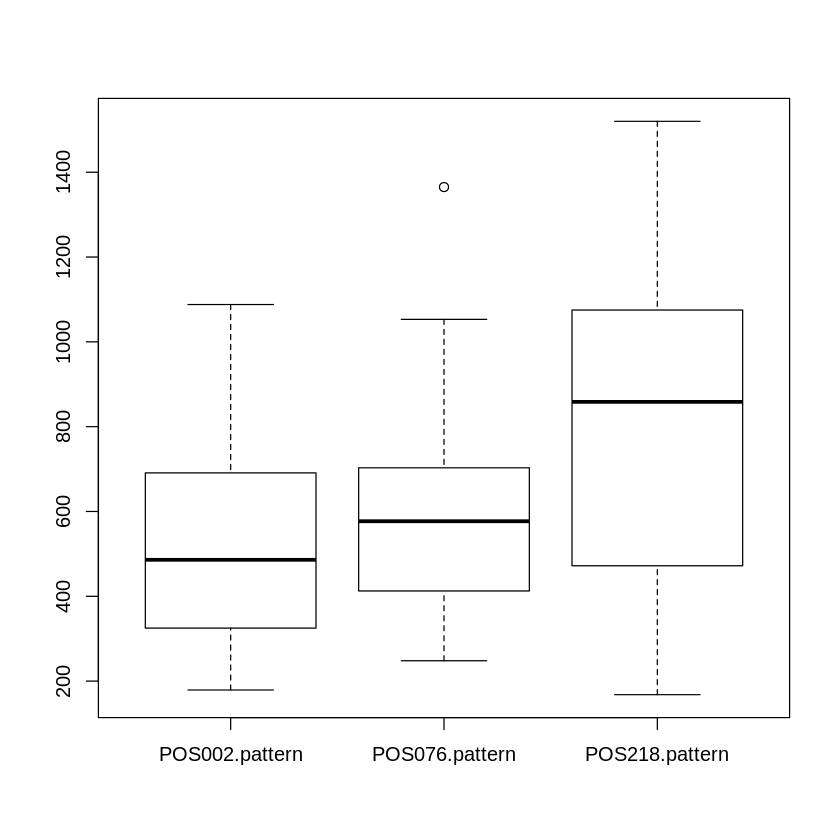

In [5]:
df <- loadCSV(server, annotationFileID)
dfLength <- subset(df, select=c("ImageNumber", "AreaShape_Area"))
boxplot(dfLength$AreaShape_Area~dfLength$ImageNumber)

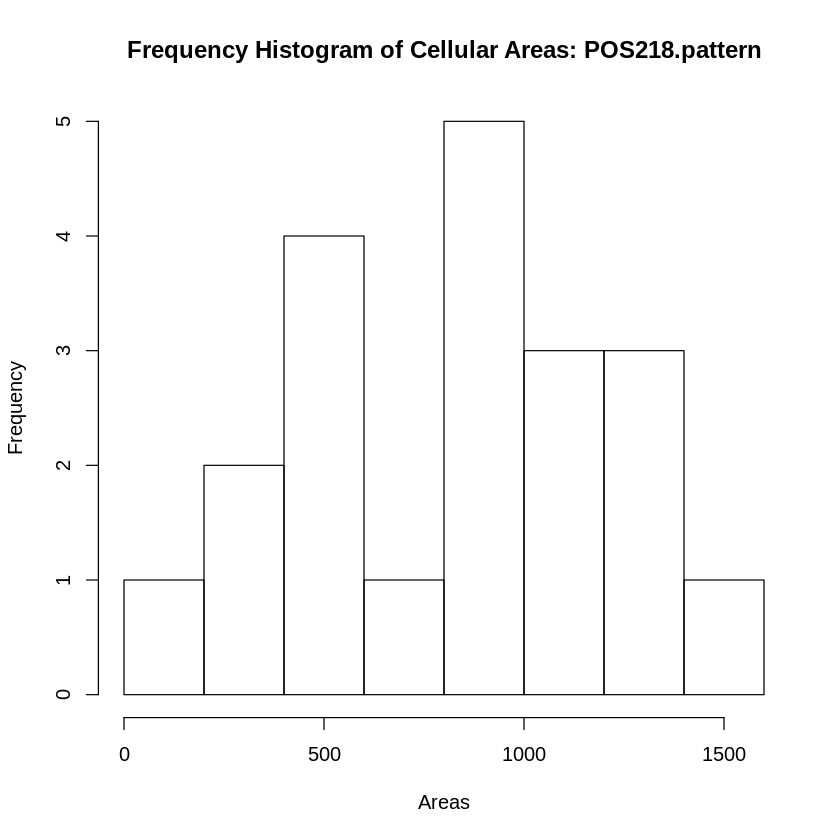

In [6]:
Areas = subset(dfLength, dfLength$ImageNumber == image_names[[1]])$AreaShape_Area
hist(Areas, main = paste("Frequency Histogram of Cellular Areas:",image_names[[1]]))

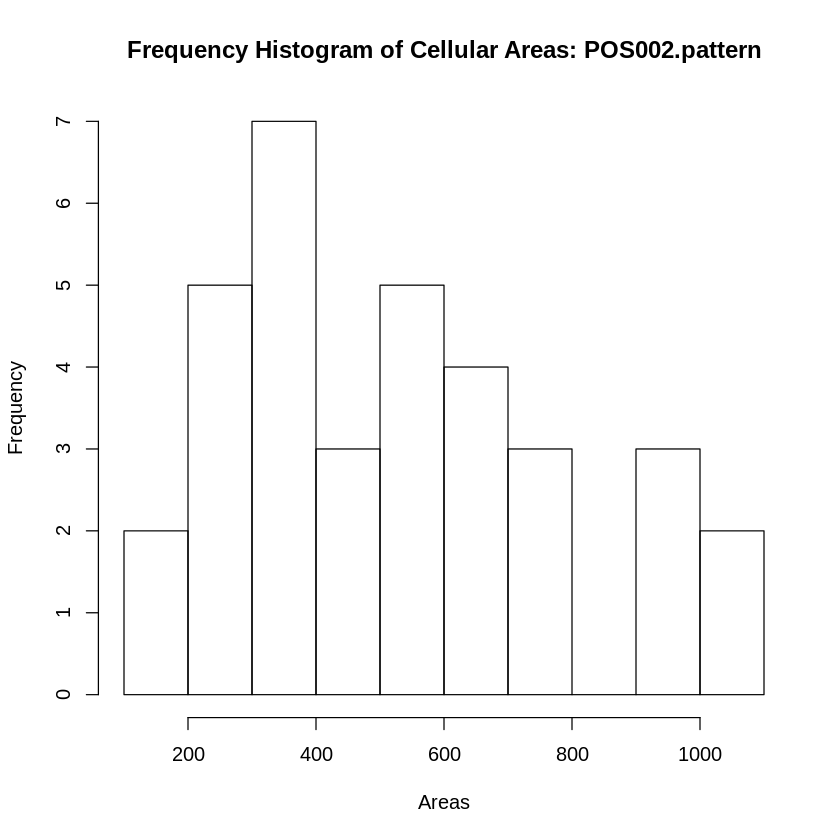

In [7]:
Areas = subset(dfLength, dfLength$ImageNumber == image_names[[2]])$AreaShape_Area
hist(Areas, main = paste("Frequency Histogram of Cellular Areas:",image_names[[2]]))

## Save Results back to OMERO

### Attach the plot to an OMERO dataset 

In [15]:
# Attach the plot to the dataset
tmpfile <- "/tmp/boxplot.png"
png(tmpfile)
boxplot(dfLength$AreaShape_Area~dfLength$ImageNumber)
dev.off()
omero_attach_plot <- attachFile(omeDataset, tmpfile)

print(paste("OMERO File Annotation ID:", omero_attach_plot@dataobject$getId()))

png 
  2

[1] "OMERO File Annotation ID: 597"


### Attach the t-test output to the dataset

In [16]:
Areas_2 <- subset(dfLength, dfLength$ImageNumber == image_names[[1]] | dfLength$ImageNumber == image_names[[2]])

tmpfile <- "/tmp/ttest_summary.txt"
cat("Here are my results:\n", file=tmpfile)
capture.output(t.test(Areas_2$AreaShape_Area~Areas_2$ImageNumber), file=tmpfile, append=TRUE)
omero_attach_file <- attachFile(omeDataset, tmpfile)

print(paste("OMERO File Annotation ID:", omero_attach_file@dataobject$getId()))

[1] "OMERO File Annotation ID: 598"


### Disconnect OMERO session

In [44]:
server_disconnect <- disconnect(server)